#  FACE-MASK DETECTION

Here we develop a model to detect if a person is wearing a mask or not from an image
The dataset to train the model is taken from https://www.kaggle.com/prithwirajmitra/covid-face-mask-detection-dataset

## Data Pre-Processing

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import PIL

In [2]:
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
def image_preprocessor(image_path):
    """
    The function takes in the file path of an image and converts into an RGB array and normalises it
    """
    image = load_img(image_path, target_size=(224, 224))
    image = img_to_array(image)
    image = preprocess_input(image)
    return image

In [3]:
import os
#Reading the image files and storing them in form of numpy arrays
directory = r"C:\\Users\\Naushin\\Desktop"

data_set = []
category = []

file_path = os.path.join(directory,"Mask")
for item in os.listdir(file_path):
    image_path = os.path.join(file_path, item)
    image = image_preprocessor(image_path)
    data_set.append(image)
    #1 for Mask
    category.append(1)


file_path = os.path.join(directory,"Non mask")    
for item in os.listdir(file_path):
    image_path = os.path.join(file_path, item)
    image = image_preprocessor(image_path)
    data_set.append(image)
    #0 for No Mask
    category.append(0)  
    
data_set = np.array(data_set)
category  = np.array(category)
 
    


In [4]:
data_set.shape

(1006, 224, 224, 3)

## Data-Augmentation and Designing the model


First, we do the test train split, and then do data augmentation on the training data

In [5]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(data_set, category, test_size=0.33, random_state=42)

In [17]:
#Constructing an image generator
from tensorflow.keras.preprocessing.image import ImageDataGenerator
aug = ImageDataGenerator(rotation_range=45,zoom_range=0.3,width_shift_range=0.3,
                               height_shift_range=0.3,shear_range=0.1,horizontal_flip=True,fill_mode="nearest")

In [18]:
#importing the necessary features
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import AveragePooling2D, Dropout, Flatten, Dense,Input
from tensorflow.keras.models import Model


In [19]:
#This is an image classification model and we are initialising the weights with  pre-trained weights on ImageNet
initial_model = MobileNetV2(include_top=False,weights="imagenet", input_tensor=Input(shape=(224, 224, 3)))

In [20]:
#creating the neural network
model = Sequential(initial_model)
model.add(AveragePooling2D(pool_size=(7, 7)))
model.add(Flatten(name="flatten"))
model.add(Dense(128, activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(1, activation="sigmoid"))


In [21]:
#freezing the layers in initial model(transfer learning)
for layer in initial_model.layers:
    layer.trainable = False

In [22]:
#Using early stopping
from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=2, patience=5)

In [23]:
#Compiling the model
model.compile(loss="binary_crossentropy", optimizer="Adam",metrics=["accuracy"])


## Training the model

The model is fitted with the training data

In [37]:
model.fit( aug.flow(X_train, y_train, batch_size=32), steps_per_epoch=len(X_train) // 32, validation_data=(X_test, y_test),
          validation_steps=len(X_test) // 32, callbacks=[early_stop], epochs=50)

Epoch 1/50
21/21 [==============================] - 23s 1s/step - loss: 0.1023 - accuracy: 0.9688 - val_loss: 0.0232 - val_accuracy: 0.9910
Epoch 2/50
21/21 [==============================] - 24s 1s/step - loss: 0.0559 - accuracy: 0.9829 - val_loss: 0.0218 - val_accuracy: 0.9880
Epoch 3/50
21/21 [==============================] - 24s 1s/step - loss: 0.0631 - accuracy: 0.9766 - val_loss: 0.0224 - val_accuracy: 0.9880
Epoch 4/50
21/21 [==============================] - 24s 1s/step - loss: 0.0386 - accuracy: 0.9875 - val_loss: 0.0225 - val_accuracy: 0.9910
Epoch 5/50
21/21 [==============================] - 25s 1s/step - loss: 0.0652 - accuracy: 0.9751 - val_loss: 0.0335 - val_accuracy: 0.9910
Epoch 6/50
21/21 [==============================] - 24s 1s/step - loss: 0.0322 - accuracy: 0.9891 - val_loss: 0.0231 - val_accuracy: 0.9880
Epoch 7/50
21/21 [==============================] - 24s 1s/step - loss: 0.0360 - accuracy: 0.9891 - val_loss: 0.0279 - val_accuracy: 0.9880
Epoch 00007: early s

<AxesSubplot:>

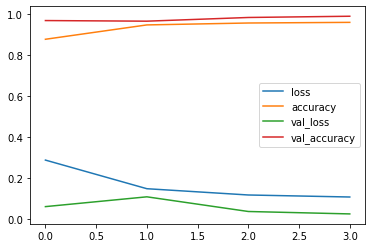

In [25]:
import pandas as pd
model_loss = pd.DataFrame(model.history.history)
model_loss.plot()

## Testing the model

In [38]:
predictions = model.predict(X_test)>0.5


In [39]:
from sklearn.metrics import classification_report,confusion_matrix

In [156]:
print(confusion_matrix(y_test,predictions))
print("\n")
print(classification_report(y_test,predictions))      


[[157   3]
 [  1 171]]


              precision    recall  f1-score   support

           0       0.99      0.98      0.99       160
           1       0.98      0.99      0.99       172

    accuracy                           0.99       332
   macro avg       0.99      0.99      0.99       332
weighted avg       0.99      0.99      0.99       332



The accuracy is 99%